In [1]:
# importing basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
# importing plot libraries
import matplotlib.pyplot as plt
import seaborn as sns
# import ml libraries
from sklearn import ensemble
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

# reading data
train = pd.read_csv(r'D:\Asha\Imp\Python\Big_Mart_Sales_Data\Train_UWu5bXk.csv')
test = pd.read_csv(r'D:\Asha\Imp\Python\Big_Mart_Sales_Data\Test_u94Q5KV.csv')


C:\Users\Ganesh\Anaconda4\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# checking the shape of the data
train.shape , test.shape

# checking column types
#train.info() , test.info()

((8523, 12), (5681, 11))

In [3]:
# Combining Train & Test
train['source'] = 'Train'
test['source'] = 'Test'
data = pd.concat([train,test],ignore_index=True,sort=True)
# re-oredering the columns as before
cols = train.columns
data = data[cols]
# displaying data header
data.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,Train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Train


In [4]:
# checking numerical data distribution
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [5]:
# checking categorical data distribution
data.describe(include=['O'])

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,source
count,14204,14204,14204,14204,10188,14204,14204,14204
unique,1559,5,16,10,3,3,4,2
top,FDU32,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1,Train
freq,10,8485,2013,1559,4655,5583,9294,8523


In [6]:
# checking missing values
train.isnull().sum() 

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
source                          0
dtype: int64

C:\Users\Ganesh\Anaconda4\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Ganesh\Anaconda4\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Ganesh\Anaconda4\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Ganesh\Anaconda4\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


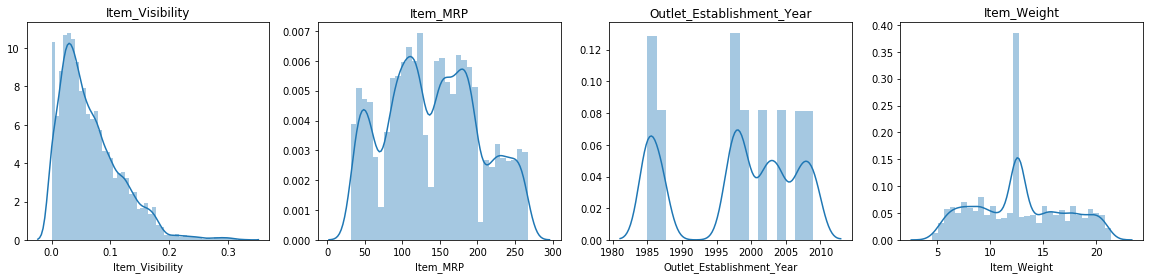

In [7]:
# Variables Analysis
# Univariate analysis for numerical variables.

# Item_Weight has missing values. Getting the median value to fill the null values
data.Item_Weight = data.Item_Weight.fillna(data.Item_Weight.median())

plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plt.title('Item_Visibility')
sns.distplot(data['Item_Visibility'])
plt.subplot(1,4,2)
plt.title('Item_MRP')
sns.distplot(data['Item_MRP'])
plt.subplot(1,4,3)
plt.title('Outlet_Establishment_Year')
sns.distplot(data['Outlet_Establishment_Year'])
plt.subplot(1,4,4)
plt.title('Item_Weight')
sns.distplot(data['Item_Weight'])

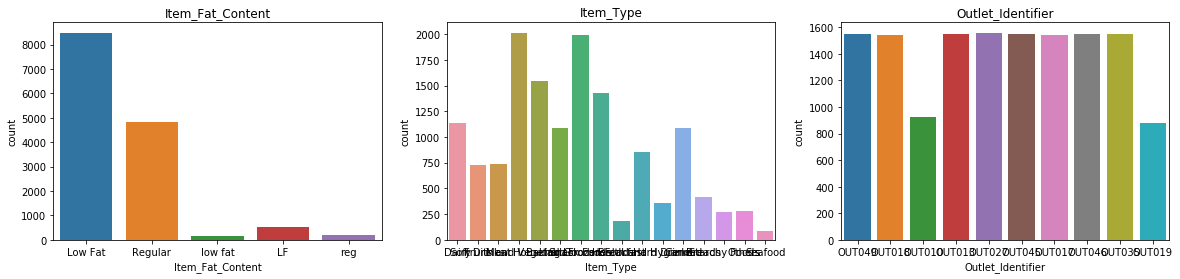

In [8]:
# Univariate analysis for categorical variables.

plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.title('Item_Fat_Content')
sns.countplot(data['Item_Fat_Content'],data=data)

plt.subplot(1,3,2)
plt.title('Item_Type')
sns.countplot(data['Item_Type'],data=data)

# Outlet_Identifier -converting to int
train['Outlet_Identifier'] = train['Outlet_Identifier'].apply(lambda x:x[-2:]).astype(int)
plt.subplot(1,3,3)
plt.title('Outlet_Identifier')
sns.countplot(data['Outlet_Identifier'],data=data)
plt.show()


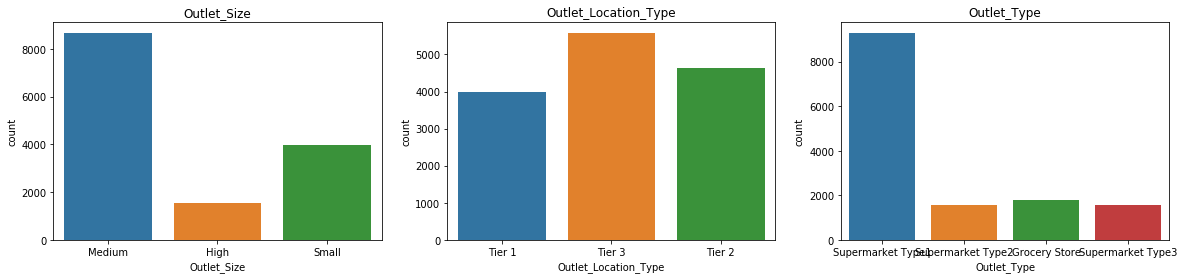

In [9]:
# Outlet_Size has missing values (4016 records). Medium is the most frequent value. So,filling missing values with it.
data.Outlet_Size.fillna('Medium',inplace=True)
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.title('Outlet_Size')
sns.countplot(data['Outlet_Size'],data=data)
plt.subplot(1,3,2)
plt.title('Outlet_Location_Type')
sns.countplot(data['Outlet_Location_Type'],data=data)
plt.subplot(1,3,3)
plt.title('Outlet_Type')
sns.countplot(data['Outlet_Type'],data=data)
plt.show()

In [10]:
# Feature Engineering and Updating Categorical variables to numeric

# Item Identifier is a unique ID. Getting first 2 letters to make a generic category
data['Item_Identifier'] = data['Item_Identifier'].apply(lambda x:x[0:2])
data['Item_Identifier'] = data['Item_Identifier'].map({'FD':1,'DR':2,'NC':3})

# Item_Fat_Content has misspelled labels. Correcting the lebels and changing to numeric.
data.Item_Fat_Content.replace(['LF','low fat','reg'],['Low Fat','Low Fat','Regular'],inplace=True)
data.Item_Fat_Content = data.Item_Fat_Content.map({'Low Fat':0,'Regular':1}).astype(int)

# Item_Visibility has zero value(879 records). Filling 0 with median
data.Item_Visibility.groupby(data.Item_Visibility).count()
data.Item_Visibility = data.Item_Visibility.apply(lambda x: data.Item_Visibility.median() if x == 0 else x)


# Outlet_Establishment_Year . Except 1985 & 1998, approximately similar count of outlets for all years. Adding outlet Age column
data.Outlet_Establishment_Year.groupby(data.Outlet_Establishment_Year).count()
data['Outlet_Age'] = data.Outlet_Establishment_Year.apply(lambda x: 2018 - x)
data.drop('Outlet_Establishment_Year',1,inplace=True)

# Coverting categorical values to Numeric
data['Outlet_Size'] = data['Outlet_Size'].map({'High':3,'Medium':2,'Small':1}).astype(int)
data['Outlet_Location_Type'] = data['Outlet_Location_Type'].map({'Tier 1':1, 'Tier 3':3, 'Tier 2':2}).astype(int)
data['Outlet_Type'] = data['Outlet_Type'].map({'Supermarket Type1':1, 'Supermarket Type2':2, 'Grocery Store':4, 'Supermarket Type3':3}).astype(int)


<Figure size 1152x288 with 0 Axes>

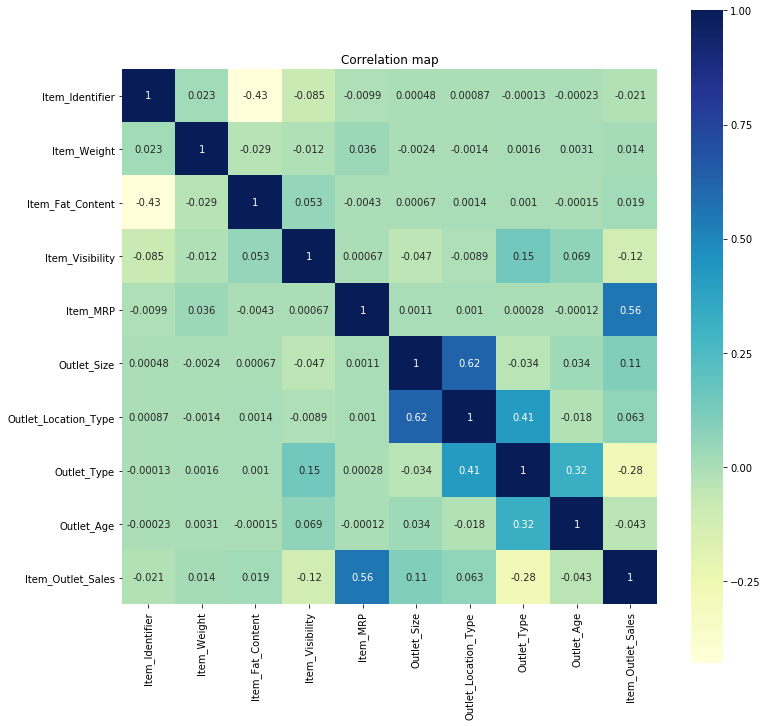

In [11]:
# multivariate analysis 
temp = data[['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type','Outlet_Age', 'Item_Outlet_Sales']]
corrmat = temp.corr(method='spearman')
plt.figure(figsize=(16,4))
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, vmax=1., square=True, cmap='YlGnBu', annot=True)
plt.title('Correlation map', fontsize=12)
plt.show()

C:\Users\Ganesh\Anaconda4\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Ganesh\Anaconda4\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Ganesh\Anaconda4\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


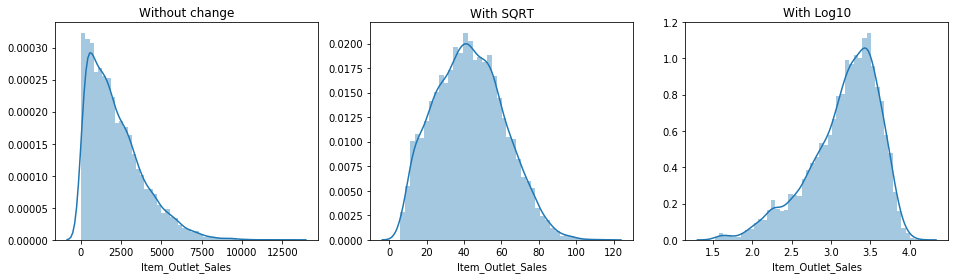

In [12]:
# Outcome variable analysis
plt.figure(figsize =(16,4))
plt.subplot(131)
plt.title('Without change')
sns.distplot(train['Item_Outlet_Sales'])
# Item_Outlet_Sales has right-skewed distribution. Taking sqrt & log10 to get a better distribution
s_train = train.Item_Outlet_Sales.apply(lambda x: np.sqrt(x))
l_train = train.Item_Outlet_Sales.apply(lambda x: np.log10(x))
plt.subplot(132)
plt.title('With SQRT')
sns.distplot(s_train)
plt.subplot(133)
plt.title('With Log10')
sns.distplot(l_train)
# Taking SQRT provides better distribution . I'll model for all 3 options and check which gives better result.

In [13]:
# Splitting the data set into Train & Test 
train = data.loc[data['source'] == 'Train']
test =  data.loc[data['source'] == 'Test']

train.drop('source',1,inplace=True)
test.drop('source',1,inplace=True)

# Visualizing relationship between outlet sales and numerical variables with corr()
#train['Item_Outlet_Sales'] = train['Item_Outlet_Sales'].apply(lambda x: np.log10(x))
#train.corr()


RMSE : Linear Regression with all features -  1152.5294168948637
Score :Test -> 0.5489764370017125
Score: Train -> 0.5694646230464253


C:\Users\Ganesh\Anaconda4\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



RMSE : Gradient Boosting with all features -  1112.6071711657835
Score :Test -> 0.5796811153383965
Score: Train -> 0.6438049668285029


C:\Users\Ganesh\Anaconda4\lib\site-packages\ipykernel_launcher.py:40: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RMSE : Random Forest with all features -  1191.3808911352621
Score :Test -> 0.5180561379681509
Score: Train -> 0.9146222008115422


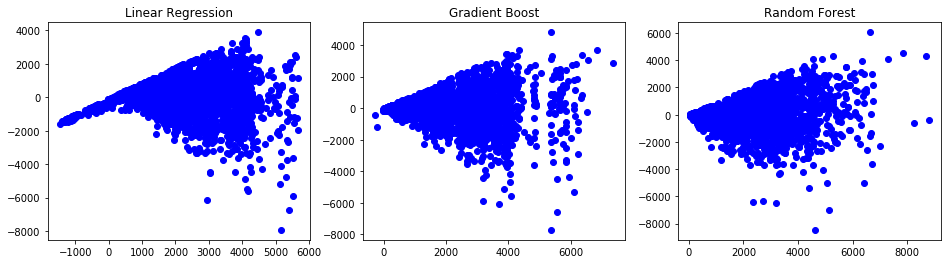

In [14]:
# build models & evaluate
# Model 1 :with all features and outcome variable as is
train = pd.get_dummies(train)
test = pd.get_dummies(test)

X = train.loc[:,train.columns != 'Item_Outlet_Sales']
Y = train.loc[:,train.columns == 'Item_Outlet_Sales']

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3 ,random_state=7)

lr = LinearRegression()
lr.fit(x_train,y_train)
predicted1 = lr.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, predicted1))
print('RMSE : Linear Regression with all features - ',rmse)
print('Score :Test ->', lr.score(x_test,y_test))
print('Score: Train ->' ,lr.score(x_train,y_train))
result = [['Target as is - Linear Regression',rmse,lr.score(x_test,y_test),lr.score(x_train,y_train)]]

# Residual Chart
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.title('Linear Regression')
x_plot = plt.scatter(predicted1,(predicted1 - y_test), c='b') 

gbr = GradientBoostingRegressor()
gbr.fit(x_train,y_train)
predicted1 = gbr.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, predicted1))
print('\nRMSE : Gradient Boosting with all features - ',rmse)
print('Score :Test ->', gbr.score(x_test,y_test))
print('Score: Train ->' ,gbr.score(x_train,y_train))
result.append(['Target as is - Gradient Boost',rmse,gbr.score(x_test,y_test),gbr.score(x_train,y_train)])
plt.subplot(132)
plt.title('Gradient Boost')
x_plot = plt.scatter(predicted1,(predicted1 - y_test.values.ravel()), c='b') 

rfr = RandomForestRegressor()
rfr.fit( x_train, y_train)
predicted1 = rfr.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test , predicted1))
print('\nRMSE : Random Forest with all features - ',rmse)
print('Score :Test ->', rfr.score(x_test,y_test))
print('Score: Train ->' ,rfr.score(x_train,y_train))
result.append(['Target as is - Random Forest',rmse,gbr.score(x_test,y_test),gbr.score(x_train,y_train)])
plt.subplot(133)
plt.title('Random Forest')
x_plot = plt.scatter(predicted1,(predicted1 - y_test.values.ravel()), c='b') 

RMSE : Linear Regression with all features -  1109.7813160238645
Score :Test -> 0.6443524320637657
Score: Train -> 0.6612823601633093


C:\Users\Ganesh\Anaconda4\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



RMSE : Gradient Boosting with all features -  1113.9890041370602
Score :Test -> 0.6583267496396854
Score: Train -> 0.7087762636042003


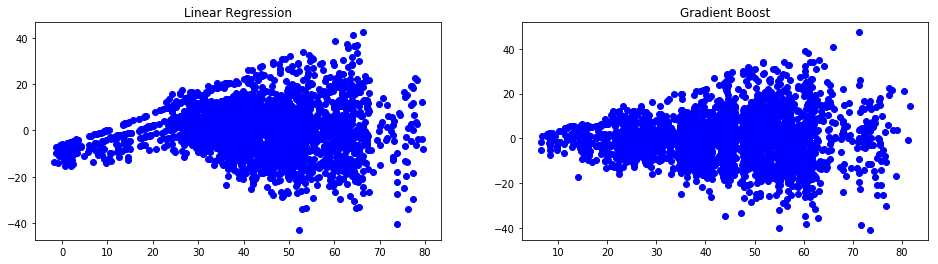

In [15]:
# Model 2: with all features and taking SQRT of outcome variable normal
strain = pd.get_dummies(train)
stest = pd.get_dummies(test)

strain['Item_Outlet_Sales'] = strain['Item_Outlet_Sales'].apply(lambda x: np.sqrt(x))
stest['Item_Outlet_Sales'] = stest['Item_Outlet_Sales'].apply(lambda x: np.sqrt(x))

X = strain.loc[:,strain.columns != 'Item_Outlet_Sales']
Y = strain.loc[:,strain.columns == 'Item_Outlet_Sales']

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3 ,random_state=7)

lr = LinearRegression()
lr.fit(x_train,y_train)
predicted2 = lr.predict(x_test)

# Converting the variable back which will help to comapre MSE values across models
rmse = np.sqrt(mean_squared_error(np.square(y_test), np.square(predicted2)))
print('RMSE : Linear Regression with all features - ',rmse)
print('Score :Test ->', lr.score(x_test,y_test))
print('Score: Train ->' ,lr.score(x_train,y_train))
result.append(['Square Root - Linear Regression',rmse,lr.score(x_test,y_test),lr.score(x_train,y_train)])

# Residual Chart
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title('Linear Regression')
x_plot = plt.scatter(predicted2,(predicted2 - y_test), c='b') 

gbr = GradientBoostingRegressor()
gbr.fit(x_train,y_train)
predicted2 = gbr.predict(x_test)
rmse = np.sqrt(mean_squared_error(np.square(y_test), np.square(predicted2)))
print('\nRMSE : Gradient Boosting with all features - ',rmse)
print('Score :Test ->', gbr.score(x_test,y_test))
print('Score: Train ->' ,gbr.score(x_train,y_train))
result.append(['Square Root - Gradient Boost',rmse,gbr.score(x_test,y_test),gbr.score(x_train,y_train)])

# Residual Chart
plt.subplot(122)
plt.title('Gradient Boost')
x_plot = plt.scatter(predicted2,(predicted2 - y_test.values.ravel()), c='b') 

RMSE : Linear Regression with all features -  1153.5534669264948
Score :Test -> 0.7069909985348419
Score: Train -> 0.7268232745997456


C:\Users\Ganesh\Anaconda4\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE : Gradient Boosting with all features -  1132.3768270687099
Score :Test -> 0.7216751278152986
Score: Train -> 0.7657100134140896


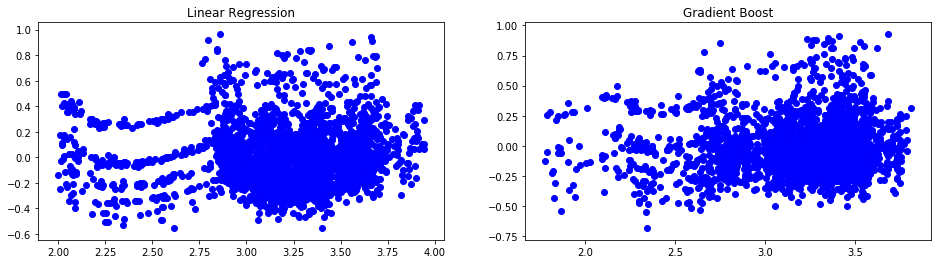

In [16]:
# Model 3: with all features and taking Log10 of outcome variable 
# Splitting the data set into Train & Test 
ltrain = pd.get_dummies(train)
ltest = pd.get_dummies(test)

ltrain['Item_Outlet_Sales'] = ltrain['Item_Outlet_Sales'].apply(lambda x: np.log10(x))
ltest['Item_Outlet_Sales'] = ltest['Item_Outlet_Sales'].apply(lambda x: np.log10(x))

X = ltrain.loc[:,ltrain.columns != 'Item_Outlet_Sales']
Y = ltrain.loc[:,ltrain.columns == 'Item_Outlet_Sales']

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3 ,random_state=7)
lr = LinearRegression()
lr.fit(x_train,y_train)
predicted3 = lr.predict(x_test)

# Converting the variable back which will help to comapre MSE values across models
rmse = np.sqrt(mean_squared_error(10**y_test, 10**predicted3))
print('RMSE : Linear Regression with all features - ',rmse)
print('Score :Test ->', lr.score(x_test,y_test))
print('Score: Train ->' ,lr.score(x_train,y_train))
result.append(['Log 10 - Linear Regression',rmse,lr.score(x_test,y_test),lr.score(x_train,y_train)])

# Residual Charts
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title('Linear Regression')
x_plot = plt.scatter(predicted3,(predicted3 - y_test), c='b') 

gbr = GradientBoostingRegressor()
gbr.fit(x_train,y_train)
predicted3 = gbr.predict(x_test)
rmse = np.sqrt(mean_squared_error(10**y_test, 10**predicted3))
print('RMSE : Gradient Boosting with all features - ',rmse)
print('Score :Test ->', gbr.score(x_test,y_test))
print('Score: Train ->' ,gbr.score(x_train,y_train))
result.append(['Log 10 - Gradient Boost',rmse,gbr.score(x_test,y_test),gbr.score(x_train,y_train)])
plt.subplot(122)
plt.title('Gradient Boost')
x_plot = plt.scatter(predicted3,(predicted3 - y_test.values.ravel()), c='b') 


In [17]:
result_df=pd.DataFrame(result)
result_df.columns = ['Model','RMSE','Test Score','Train Score']
result_df
# Conclusion : Linear regression model with square root target has the least RMSE ,but based on R Squared and Residual Plots,
# Gradient Boost model with Log10 target is the best way.

,Model,RMSE,Test Score,Train Score
0,Target as is - Linear Regression,1152.529417,0.548976,0.569465
1,Target as is - Gradient Boost,1112.607171,0.579681,0.643805
2,Target as is - Random Forest,1191.380891,0.579681,0.643805
3,Square Root - Linear Regression,1109.781316,0.644352,0.661282
4,Square Root - Gradient Boost,1113.989004,0.658327,0.708776
5,Log 10 - Linear Regression,1153.553467,0.706991,0.726823
6,Log 10 - Gradient Boost,1132.376827,0.721675,0.765710
